<a href="https://colab.research.google.com/github/Bryan-Az/LLaMA-RAG/blob/main/llm_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'''
This is a simple notebook and assignment to test the functionality of various
LLM libraries in Python.

Author: Alexis Ambriz
Date: 2024-02-16
Link to credit to the original notebook: https://www.youtube.com/watch?v=sYliwvml9Es
Link to credit the original dataset: https://huggingface.co/knowrohit07
'''


' \nThis is a simple notebook and assignment to test the functionality of various \nLLM libraries in Python.\n\nAuthor: Alexis Ambriz\nDate: 2024-02-16\nLink to credit to the original notebook: https://www.youtube.com/watch?v=sYliwvml9Es\nLink to credit the original dataset: https://huggingface.co/knowrohit07\n'

In [ ]:
# Used throughout the notebook
import tokenize, ast
from io import BytesIO
import pandas as pd
import matplotlib.pyplot as plt
# Used in the Token Generation section
! pip install tiktoken
from tiktoken import encoding_for_model
# Used in the OpenAI API section
! pip install openai==0.28.0
from openai import ChatCompletion,Completion
from fastcore.utils import nested_idx
# Used in the 'Create a code interpreter' section
from pydantic import create_model
import inspect, json
from inspect import Parameter
from transformers import AutoModelForCausalLM,AutoTokenizer
import torch
# Used in retrieval augmented generation
! python -m pip install wikipedia-api
! pip install sentence_transformers
from wikipediaapi import Wikipedia
from sentence_transformers import SentenceTransformer
import torch.nn.functional as F
# Used in finetuning section
import openai
#Specific to google colab environment
#! pip install pyarrow==14.0.0 (!!! UN-comment on first run, and then restart session & comment & RE-run)
! pip install peft
! pip install llama-cpp-python
! pip install datasets
import datasets
from peft import PeftModel
# Used in LLaMA section (Specific to Mac environment)
#! CMAKE_ARGS="-DLLAMA_METAL=on" pip install llama-cpp-python
from llama_cpp import Llama


In [ ]:
# specific to colab enviroment
#!pip uninstall -y transformers (!!! UN-comment on first run, and then restart session & comment & RE-run)
#!pip install git+https://github.com/huggingface/transformers
from transformers import AutoModelForCausalLM,AutoTokenizer


In [ ]:
from transformers import BitsAndBytesConfig

# Exploring the Data
The following data will be used in the following experiments/fine-tuning of the models. As I am currently interested in a project in the medical field, I thought it would be useful to use the datasets package to download medical data and attempt to analyze this data for insights. Below is a brief exploratory data analysis preparing it to be used for experimentation with LLM's (Large Language Models) such as LLaMA (a LLM made by Meta AI).

In [ ]:
from datasets import load_dataset

dataset = load_dataset("knowrohit07/know_medical_dialogues")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'output'],
        num_rows: 480
    })
})

In [ ]:
# Given the entire dataset consists of 480 rows
# we will use 390 (90%) rows for training and 96 (20%) rows for testing
train_med_data = dataset['train'][:384]
test_med_data = dataset['train'][384:]

In [ ]:
test_med_data.keys()

dict_keys(['instruction', 'input', 'output'])

In [ ]:
train_med_features = pd.DataFrame(train_med_data)
test_med_features = pd.DataFrame(test_med_data)
test_med_features

,instruction,input,output
0,the symptoms of covid sound like my asthma sym...,,in brief: fever/flu like sx covid-19 is typica...
1,"my son has a fever, i am concerned due to the ...",,in brief: covid-19 unlikely. the usual infecti...
2,is covid-19 airborne? if someone sick was coug...,,yes. covid-19 is an airborne transmitted virus...
3,this morning i woke up with an extremely dry c...,,virus. these symptoms are characteristic of a ...
4,where can i get tested for corona if i am in t...,,in brief: consult with your gp you cannot just...
...,...,...,...
91,my 5 year old son woke up not feeling well. i ...,,"in brief: arrange testing stay home, provide f..."
92,i have a dry cough and sore throat- it's been ...,,in brief: covid good guidelines can be found a...
93,how do i know if i have a normal cold or maybe...,,common cold with sin. the corona virus causes ...
94,hi- i was diagnosed a month ago with community...,,hello! just because you have previously had a ...


As we can see, the training and testing datasets have been pre-constructred and contain only the necessary columns for training a LLM.

 > Input: A blank string for all records indicates that this is potentially meant to represent the instruction, and the instruction is meant to be the "prompt/context".

 > Output: The desired response that the model should make given the data.

 > Instruction: The given query an expected user of the LLM or chatbot will potentially make based on the data.

 As we can see this dataset is far from complete, so let's experiment with the data and identify how the model can learn from it!

## Describing the data

In [ ]:
print(test_med_features.shape)
print(train_med_features.shape)

(96, 3)
(384, 3)


In [ ]:
test_med_features.describe()

,instruction,input,output
count,96,96,96
unique,95,1,95
top,should i shave my beard to reduce my chances o...,,maybe. do video w/
freq,2,96,2


The test dataset shows that my hypothesis was correct and the input feature in both the train and test datasets were similar and it is mostly a empty placeholder (maybe for a potential future feature?). Furthermore, there is one record/observation in the output/instruction features which is repeated meaning that not every column is unique. However, only one is repeated meaning most of the data is unique, which is a good sign.

In [ ]:
train_med_features.describe()

,instruction,input,output
count,384,384,384
unique,376,1,379
top,can covid-19 be transmitted sexually? can any ...,,without any details it's impossible to say.
freq,3,384,2


We see that there is 379 unique records out of a total 384 meaning there is 5 non-unique records in the train dataset. Two of those are the top record having 2-3 occurrences (meaning there is probably only one or two repeated records and none of them are repeated more than once), once again a good sign meaning most of the data is meaningful.

In [ ]:
# Since input is an empty feature, we can drop it
train_med_features = train_med_features.drop(columns=['input'])
test_med_features = test_med_features.drop(columns=['input'])

# Experiment | Token Generation
A basic LLM model is able to convert text into word tokens. Each word is encoded into a numerical representation that the machine learning model can understand using a process that uses "text embeddings" where every word is hashed into a hashmap (or other indexing data structure) and then the value for each hashed word is found via a mathematical function that determines a value by comparing the word's relation to every other word. A common method is to use the cosin similarity.

In the case of the "text-davinci-003" LLM, a transformer model, the text is first encoded using word embeddings into tokens using "byte pair encodings". Source: https://huggingface.co/learn/nlp-course/chapter6/5?fw=pt

In [ ]:
# the input to the encoder is the name of the model and the output is the tokenizer specific to that model
encoder = encoding_for_model("text-davinci-003") # the encoder is a wrapper around the tokenizer
token_sample = encoder.encode("What is the treatment for fever?")

In [ ]:
token_sample

[2061, 318, 262, 3513, 329, 17372, 30]

Hypothesis: The encoder has similar values for filler words and punctuation. Let's test it out and compare it to the token sample and another filler as an control sample.

In [ ]:
filler = '. ? ! and or but so because'
filler_sample = encoder.encode(filler)
filler_sample

[13, 5633, 5145, 290, 393, 475, 523, 780]

In [ ]:
test_filler = '; : " [ it she he an` \\'
test_filler_sample = encoder.encode(test_filler)
test_filler_sample

[26, 1058, 366, 685, 340, 673, 339, 281, 63, 3467]

In [ ]:
filler_sample_mean = sum(filler_sample)/len(filler_sample)
sentence_sample_mean = sum(token_sample)/len(token_sample)
test_filler_sample_mean = sum(test_filler_sample)/len(test_filler_sample)

In [ ]:
print(filler_sample_mean)
print(sentence_sample_mean)
print(test_filler_sample_mean)

1656.5
3412.1428571428573
729.8


In [ ]:
# lets find the difference between the filler and the sentence
diff_filler_sentence = abs(filler_sample_mean - sentence_sample_mean)
# now, lets find the difference between the filler and the test filler
diff_filler_test_filler = abs(filler_sample_mean - test_filler_sample_mean)
print(diff_filler_sentence)
print(diff_filler_test_filler)

1755.6428571428573
926.7


## Conclusion
My intuition tells me that since the mean difference between the filler sample and the sample natural sentence is almost 2x as much as between the filler sample and the test filler, that my hypothesis is on the right track. This may be due to how text embeddings preserve the syntactic meaning of words and text, and filler words may be clustering together within the embeddings the encoder is using to create the tokens.

To know if my hypothesis is mathematically correct, I would need more samples and an A/B bootstrapping test to answer my hypothesis properly. However, let's move on for now!

# Experiment | Instruction Tuning

## OpenOrca

**Beware!**: The following dataset is large and will take 3-5 minutes to load. It has 2.91 million records and 4 features and is 5gb in total memory. To store the data, pandas cannot be used or it will be very slow. A better option is to use an RDBMS or a Torch or Tensorflow tensor. Since I simply want to describe and view the data, a small sample will be enough to display with Pandas.

In [ ]:
openorca_data = datasets.load_dataset('Open-Orca/OpenOrca')

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
openorca_data.keys()

dict_keys(['train'])

In [ ]:
sample_size = 5000
openorca_sample = openorca_data['train'][:sample_size]

In [ ]:
# using a pandas dataframe to structure the data
openorca_llm_data = pd.DataFrame(openorca_sample)
openorca_llm_data.shape

(5000, 4)

In [ ]:
openorca_llm_data.describe()

,id,system_prompt,question,response
count,5000,5000,5000,5000
unique,5000,17,4879,4888
top,niv.242684,You are an AI assistant. User will you give yo...,Write a sentence not in English.,Yes
freq,1,1163,45,15


We see from the above description, that all four features are text features which is natural given the OpenOrca dataset is used to train and instruct a LLM. A key difference between the Open-Orca/OpenOrca and the knowrohit07/know_medical_dialogues datasets is that OpenOrca has a "system_prompt" feature that may have been meant to replace the "instruction" feature in the medical dialogues dataset, and a question feature that may have been meant to replace the "input" feature. Finally, it also has a "response" feature that may have been meant to replace the "output" feature.

It also has some duplicate prompts, questions, and responses. However, the OpenOrca dataset is much larger and thus the number of duplicates may not be statistically significant.

Let's use 3 sample prompts from the OpenOrca dataset to test out if the model returns the expected result in the following section. For now, lets simply take a sample from the orca dataset.

In [ ]:
openorca_sample = openorca_llm_data.sample(3)
openorca_sample

,id,system_prompt,question,response
89,flan.820860,"You are a helpful assistant, who always provid...",Generate a sentence about this data: Blue Spic...,Blue Spice is a restaurant by the river where ...
3041,t0.460620,You are an AI assistant. You will be given a t...,Extract the answer to the question from the fo...,The first event mentioned in the context is th...
3396,t0.848566,You are an AI assistant. Provide a detailed an...,Q:Here is a review left by a customer on a pro...,"Based on the review provided, the customer app..."


## ChatGPT Reasoning
In this section I experiment with OpenOrca data and ChatGPT. Will ChatGPT answer according to the expected "result" and "system_prompt" features?

In [ ]:
openorca_sample.iloc[0]

id                                                     flan.820860
system_prompt    You are a helpful assistant, who always provid...
question         Generate a sentence about this data: Blue Spic...
response         Blue Spice is a restaurant by the river where ...
Name: 89, dtype: object

In [ ]:
openorca_sample.iloc[1]

id                                                       t0.460620
system_prompt    You are an AI assistant. You will be given a t...
question         Extract the answer to the question from the fo...
response         The first event mentioned in the context is th...
Name: 3041, dtype: object

In [ ]:
openorca_sample.iloc[2]

id                                                       t0.848566
system_prompt    You are an AI assistant. Provide a detailed an...
question         Q:Here is a review left by a customer on a pro...
response         Based on the review provided, the customer app...
Name: 3396, dtype: object

## Conclusion

In conclusion, it looks like ChatGPT was able to respond accurately according to the expected 'question' and 'response' features for each sample record in the OpenOrca data for each test.

However, it seems ChatGPT did not respond in the way expected by the "system_prompt" feature for every test (for example, in the second test).

From my perspective, it seems GPT responded better to a more detailed and lengthy system prompt where it is asked to assume an audience role of somekind (e.g a 5-year-old).

# Experiment | Advanced Data Analysis
In this section I will use ChatGPT's "Advanced Data Analysis" mode to generate code that may or may not work to accomplish a code generation task.

### The image used...
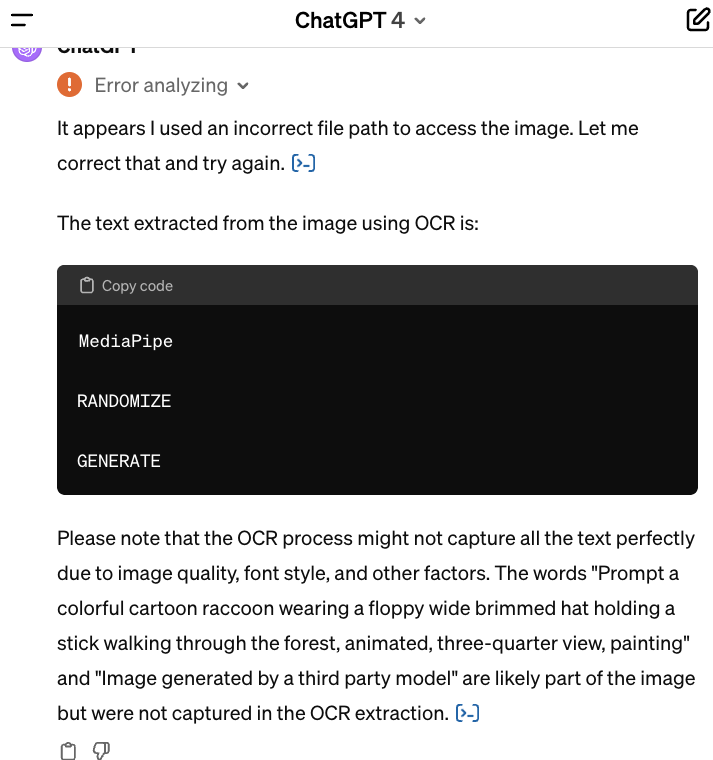

## Conclusion
It looks like ChatGPT made an initial mistake loading the image, then corrected itself. It also provided the code used to extract the text from the image, and also provided me with the text it extracted. Although it was not able to extract the full text, it was able to extract the three biggest words on the image by font size.

MediaPipe, Randomize, and Generate.

# Experiment | OpenAI API

In this section, I will use the OpenAI API to create a code interpreter. "Code interpretation" is basically a task within a text query where a user submits a code snippet within the chat and asks a question to the chatbot/A.I for advise on editing or adding logic within the code example. In this experiment, I ask my own question and submit my own sample snippet and attempt to execut the code that the A.I has responded with. Since the API is not able to execute the code within the query remotely, I will have to execute the code locally.

## Code Interpreting

In [ ]:
#this is an example function to send to the gpt and then have it interpret the code
#run the code with example f
def matheq(x:int, y:int, z:int):
    "adds the squares of x, y, and z together and returns the result"
    return x**2 + y**2 + z**2

In [ ]:
#this is an important fx to format the code as input to the gpt3 model
def schema(f):
    kw = {n:(o.annotation, ... if o.default==Parameter.empty else o.default)
          for n,o in inspect.signature(f).parameters.items()}
    s = create_model(f'Input for `{f.__name__}`', **kw).schema()
    return dict(name=f.__name__, description=f.__doc__, parameters=s)

In [ ]:
#system is like the system_prompt feature of the openorca dataset
def askgpt(user, system=None, model="gpt-3.5-turbo", **kwargs):
    msgs = []
    if system: msgs.append({"role": "system", "content": system})
    msgs.append({"role": "user", "content": user})
    return ChatCompletion.create(model=model, messages=msgs, **kwargs)

In [ ]:
openai.api_key ='enter-your-api-key'

In [ ]:
# the system parameter is the priming of the model / the model context
math_sys = "Take the role of a math teacher. Help me with the following problem: I want to find x,y,z inputs for a math equation. The code I have is this. Help me understand it and improve it."

In [ ]:
# this function calls chatgpt api and sends the function to the gpt model
# the gpt model will then interpret the function and return the output
# the output will be the result of the function (it will be code as a string formatted to be ran in python)
c = askgpt("Use the `matheq` function to create and test 2 inputs. Each input has 3 elements (x, y, z). Generate one input you think will work for the function, and an edge case that will break it.",
           system = math_sys,
           functions=[schema(matheq)])

In [ ]:
funcs_ok = {'matheq', 'python'}
# this function uses the response returned by the chatgpt api after being asked a code inerpreting question and executes the code locally
# --- the way getting the text is different it will be c.choice[0].message.context
def call_func(c):
    fc = c.choices[0].message.function_call
    print(fc)
    if fc.name not in funcs_ok: return print(f'Not allowed: {fc.name}')
    f = globals()[fc.name]
    return f(**json.loads(fc.arguments))

In [ ]:
result = call_func(c)
print(result)

{
  "name": "matheq",
  "arguments": "{\"x\":2,\"y\":3,\"z\":4}"
}
29


In [ ]:
c.choices[0].message.content

'Here are two inputs using the `matheq` function:\n\n1. Input 1 (Valid Input):\n   - x = 2, y = 3, z = 4\n   This input is likely to work fine with the `matheq` function as it contains valid integer values for x, y, and z.\n\n2. Input 2 (Edge Case):\n   - x = -2, y = 0, z = "abc"\n   This input is an edge case that could potentially break the `matheq` function as it includes a non-integer value for z. It\'s important to note that the function expects integer values for x, y, and z, so providing a non-integer value might cause an error.\n\nLet\'s test these inputs with the `matheq` function and see the results.'

## Conclusion

Using the above methods, I was able to have the ChatGPT API interpret my code and create test inputs for my function that processed a math equation. It successfully crafted test inputs as an edge case that could help develop an improvement to the original function.

# Experiment | PyTorch, RAG & LLaMA
Also known as, Retrieval Augmented Generation & LLM by Meta AI

## PyTorch

### LLaMA is a closed-source model requiring approval
You will be required to apply for access before attempting to run the code below.

The following code to access the meta-llama model is raising an error due to not having requested access and signing in to the huggingface CLI before running it. Once access is given, it will be possible to use the model for inference. For no, I'll be skipping to the next section.

In [ ]:
# defining the model to be used
mn = "meta-llama/Llama-2-7b-hf"
# creating the model (automodel is taken from the transformers library  )
model = AutoModelForCausalLM.from_pretrained(mn, device_map=0, load_in_8bit=True)

OSError: You are trying to access a gated repo.
Make sure to have access to it at https://huggingface.co/meta-llama/Llama-2-7b-hf.
401 Client Error. (Request ID: Root=1-65d1221a-40fc5c2f45f37f03651ab2e1;c4855c6a-c3f1-456e-ba69-0980aac058ea)

Cannot access gated repo for url https://huggingface.co/meta-llama/Llama-2-7b-hf/resolve/main/config.json.
Repo model meta-llama/Llama-2-7b-hf is gated. You must be authenticated to access it.

### StableBeluga is Open-Source and doesn't require approval.

It requires CUDA (recommended to run in google colab or other NVIDIA env)

In [ ]:
stablebeluga_sys_prompt = "### System:\nYou are Stable Beluga, an AI that follows instructions extremely well. Help as much as you can!\n\n"

In [ ]:
def make_prompt(user, syst=stablebeluga_sys_prompt): return f"{syst}### User: {user}\n\n### Assistant:\n"

In [ ]:
query = "What is the treatment for diabetes?"

In [ ]:
make_prompt(query)

'### System:\nYou are Stable Beluga, an AI that follows instructions extremely well. Help as much as you can!\n\n### User: What is the treatment for diabetes?\n\n### Assistant:\n'

In [ ]:
#gen(make_prompt(query), 150)

In [ ]:
mn = "stabilityai/stablelm-zephyr-3b"
model = AutoModelForCausalLM.from_pretrained(mn, device_map=0, torch_dtype=torch.bfloat16, trust_remote_code=True)

config.json:   0%|          | 0.00/840 [00:00<?, ?B/s]

configuration_stablelm_epoch.py:   0%|          | 0.00/5.49k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/stabilityai/stablelm-zephyr-3b:
- configuration_stablelm_epoch.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_stablelm_epoch.py:   0%|          | 0.00/38.4k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/stabilityai/stablelm-zephyr-3b:
- modeling_stablelm_epoch.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/5.59G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

In [ ]:
#the autotokenizer  is also taken from the transformers library
# the tokenizer is used to convert the input to the model into tokens
# the input is the name of the model used
token_maker = AutoTokenizer.from_pretrained(mn)
prompt = "What is the treatment for diabetes?"
tokens_made = token_maker(prompt, return_tensors="pt")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
### --- THIS CODE REQUIRES MODEL ACCESS TO RUN ---
def gen(p, maxlen=15, sample=True):
    toks = token_maker(p, return_tensors="pt")
    res = model.generate(**toks.to("cuda"), max_new_tokens=maxlen, do_sample=sample).to('cpu')
    return token_maker.batch_decode(res)

In [ ]:
gen(make_prompt(query), 150)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


["### System:\nYou are Stable Beluga, an AI that follows instructions extremely well. Help as much as you can!\n\n### User: What is the treatment for diabetes?\n\n### Assistant:\nStable Beluga: As an AI language model, I don't have personal experiences or views. However, the treatment for diabetes depends on the type of diabetes and its severity. The main goal of diabetes treatment is to manage blood sugar levels, maintain good health, and prevent complications. Treatment options include lifestyle changes, medications, and insulin therapy, depending on the specific needs of the individual. It's important for people with diabetes to work closely with their healthcare team to develop an individualized treatment plan.\n\n- For type 1 diabetes, treatment typically starts with insulin injections, often combined with tablets to help control blood sugar levels. Over time, individuals may transition to a combination of insulin and oral medications. In some cases, individuals may also receive r

## RAG (Retrieval Augmented Generation)

In [ ]:
# to fine-tune, we will be using the medical dataset
train_med_features.head()


,instruction,output
0,throat a bit sore and want to get a good imune...,during this pandemic. throat pain can be from ...
1,"hey there i have had cold ""symptoms"" for over ...",yes. protection. it is not enough symptoms to ...
2,i have a tight and painful chest with a dry co...,"possible. top symptoms include fever, dry coug..."
3,what will happen after the incubation period f...,"in brief: symptoms if you are infected, sympto..."
4,just found out i was pregnant. yesterday diagn...,thanks for your question on healthcare magic.i...


In [ ]:
train_med_data.keys()

dict_keys(['instruction', 'input', 'output'])

In [ ]:
sys_prompt = """SYSTEM: Use the following contextual information to concisely answer the question.

USER: {}
===
{}
ASSISTANT:"""

In [ ]:
def sql_prompt(d): return sys_prompt.format(d["instruction"], d["output"])

In [ ]:
print(sql_prompt(dataset['train'][0]))

SYSTEM: Use the following contextual information to concisely answer the question.

USER: throat a bit sore and want to get a good imune booster, especially in light of the virus. please advise. have not been in contact with nyone with the virus.
===
during this pandemic. throat pain can be from a strep throat infection (antibiotics needed), a cold or influenza or other virus, or from some other cause such as allergies or irritants. usually, a person sees the doctor (call first) if the sore throat is bothersome, recurrent, or doesn't go away quickly. covid-19 infections tend to have cough, whereas strep throat usually lacks cough but has more throat pain. (3/21/20)
ASSISTANT:


## Finetuning
> Required: another base model to be trained

> or, another pre-trained model to be imported

To proceed with fine-tuning, another pre-trained model will need to be created and saved and then the commands below can be run like:

In [ ]:
other_model = "model/example"
# the "combined"/fine-tuned model
model = PeftModel.from_pretrained(model, other_model)
model = model.merge_and_unload()
model.save_pretrained("medical-model")
# as there has not been a smaller model created based on the data in
# the train-med-data dataset, this is placeholder code

# Conclusion
The above experiments have guided me in the process of utilizing open and closed source models to create inference on text data and incorporate LLM (Large Language Model) methods, such as creating calls to an API and recieve the responses to answer questions or interpret code.

In the future, I see implications for fine-tuning pre-trained LLM's such as the open-source stable LM Zephy/Beluga using retrieval augmented generation (RAG) on novel data.